In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

cwd = os.getcwd()
parts = cwd.split(os.sep)

repo_root = os.path.dirname(cwd)
sys.path.insert(1, repo_root)

from scripts.helpers import *  

In [3]:
# =========================
# Load data 
# =========================
main_dir = r'/Users/garambois/Desktop/EPFL/MASTER/NX_MA1/MA_1/NSM/BIO-482-project'  
print('Main working directory:', main_dir)

figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)

data_path = os.path.join(main_dir, 'Data')

fname = 'Data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: /Users/garambois/Desktop/EPFL/MASTER/NX_MA1/MA_1/NSM/BIO-482-project


In [4]:
# =========================
# Utility functions
# =========================
def ms_to_samples(ms, fs):
    return int(round((ms / 1000.0) * fs))

def get_segment(y, i0, i1):
    if i0 < 0 or i1 > len(y) or i1 <= i0:
        return None
    return y[i0:i1]

def linear_slope(t_seg, vm_seg):
    if len(vm_seg) < 2:
        return np.nan
    a, b = np.polyfit(t_seg, vm_seg, 1)
    return a

def compute_features(vm_seg, t_seg):
    slope = linear_slope(t_seg, vm_seg)
    mean_vm = float(np.mean(vm_seg))
    std_vm = float(np.std(vm_seg, ddof=1)) if len(vm_seg) > 1 else np.nan
    return slope, mean_vm, std_vm

def has_spike_in_interval(spike_times_s, t0, t1):
    st = np.asarray(spike_times_s, dtype=float)
    return np.any((st >= t0) & (st < t1))

def extract_pre_spike_window(vm, t, t_thr, win_ms, spike_times_s):
    dt = np.median(np.diff(t))
    fs = 1.0 / dt
    win_samp = ms_to_samples(win_ms, fs)

    i_thr = np.searchsorted(t, t_thr)
    i0 = i_thr - win_samp
    i1 = i_thr

    vm_seg = get_segment(vm, i0, i1)
    t_seg  = get_segment(t,  i0, i1)
    if vm_seg is None:
        return None, None

    eps = 1e-9
    if has_spike_in_interval(spike_times_s, t_seg[0], t_thr - eps):
        return None, None

    return vm_seg, t_seg

def sample_baseline_window(vm, t, spike_times_s, win_ms,
                           guard_pre_ms=20, guard_post_ms=10, max_tries=500):
    win_s = win_ms / 1000.0
    pre_guard_s = guard_pre_ms / 1000.0
    post_guard_s = guard_post_ms / 1000.0

    t_min = t[0] + pre_guard_s + win_s
    t_max = t[-1] - post_guard_s
    if t_max <= t_min:
        return None, None, None

    for _ in range(max_tries):
        t_rand = np.random.uniform(t_min, t_max)
        t0 = t_rand - win_s
        t1 = t_rand

        if has_spike_in_interval(spike_times_s, t0 - pre_guard_s, t1 + post_guard_s):
            continue

        i0 = np.searchsorted(t, t0)
        i1 = np.searchsorted(t, t1)
        vm_seg = get_segment(vm, i0, i1)
        t_seg  = get_segment(t,  i0, i1)
        if vm_seg is None:
            continue

        return vm_seg, t_seg, t_rand

    return None, None, None

In [ ]:
# =========================
# Parameters
# =========================
# Window durations to analyze (in ms)
WINDOWS_MS = [2.5, 3.5, 4.5]  
N_BASELINE_PER_SPIKE = 1


# Short: High freq bursts (10ms = 100Hz)
SHORT_ISI_MS = 3 

# Long: Rested state 
LONG_ISI_MS = 5  

# ======================================================
# 1. DEFINE THE DATA EXTRACTION HELPER FUNCTION
# ======================================================
def get_trace_from_row(row):
    """
    Extracts t, vm, and parameters from a single row of the DataFrame.
    """
    # Verify your column names here. 
    # Usually 'Sweep_MembranePotential' or 'vm_trace' depending on your cleaning step.
    vm = row['Sweep_MembranePotential'] 
    fs = row['Sweep_MembranePotential_SamplingRate']
    
    dt = 1.0 / fs
    t = np.arange(len(vm)) * dt
    
    cell_type = row['Cell_Type'] if 'Cell_Type' in row else 'Unknown'
    
    # Use provided threshold slope or default
    if 'Cell_APThreshold_Slope' in row:
        ap_slope_thr = row['Cell_APThreshold_Slope']
    else:
        ap_slope_thr = 20.0 
        
    return t, vm, fs, cell_type, ap_slope_thr

# ======================================================
# 2. MAIN ANALYSIS LOOP
# ======================================================
rows = []
print(f"Starting analysis on {len(data_df)} sweeps...")

for idx, row in data_df.iterrows():
    
    # --- A. Get Trace Data ---
    try:
        t, vm, fs, cell_type, ap_slope_thr = get_trace_from_row(row)
    except Exception as e:
        continue

    # --- B. Detect Spikes ---
    ap_out = Function_Detect_APs(vm, fs, ap_slope_thr)

    if ap_out is None or len(ap_out) == 0:
        continue
        
    # t_thr_list in seconds
    t_thr_list = ap_out[:, 0]
    t_thr_list = np.sort(t_thr_list)

    # --- C. Analyze Each Spike ---
    for k, t_thr in enumerate(t_thr_list):

        # 1. Calculate ISI (History)
        isi_ms = np.nan
        isi_cat = None
        
        # We can only calculate ISI if there is a previous spike (k > 0)
        if k > 0:
            isi_ms = (t_thr - t_thr_list[k - 1]) * 1000.0
            
            # Categorize based on your NEW physiological thresholds
            if isi_ms < SHORT_ISI_MS:
                isi_cat = "Short" # < 10ms 
            elif isi_ms > LONG_ISI_MS:
                isi_cat = "Long"  # > 50ms
            else:
                isi_cat = "Mid"   # 10ms - 50ms

        # 2. Extract Pre-AP Windows
        for win_ms in WINDOWS_MS:
            vm_seg, t_seg = extract_pre_spike_window(vm, t, t_thr, win_ms, t_thr_list)
            
            if vm_seg is None:
                continue

            slope, mean_vm, std_vm = compute_features(vm_seg, t_seg)

            rows.append({
                "cell_id": row.name, 
                "cell_type": cell_type,
                "condition": "Pre-AP",
                "win_ms": win_ms,
                "slope_V_per_s": slope,
                "mean_V": mean_vm,
                "std_V": std_vm,
                "t_anchor_s": t_thr,
                "isi_ms": isi_ms,
                "isi_cat": isi_cat
            })

            # 3. Extract Baseline Windows
            # Only do this ONCE per spike (not for every window size) to save time,
            # or do it for every window size if you want matched controls.
            # Your current indentation does it for every window size, which is correct.
            for _ in range(N_BASELINE_PER_SPIKE):
                b_vm, b_t, t_rand = sample_baseline_window(
                    vm, t, t_thr_list, win_ms,
                    guard_pre_ms=20, guard_post_ms=10
                )
                if b_vm is None:
                    continue

                b_slope, b_mean, b_std = compute_features(b_vm, b_t)

                rows.append({
                    "cell_id": row.name,
                    "cell_type": cell_type,
                    "condition": "Baseline",
                    "win_ms": win_ms,
                    "slope_V_per_s": b_slope,
                    "mean_V": b_mean,
                    "std_V": b_std,
                    "t_anchor_s": t_rand,
                    "isi_ms": np.nan, # Baseline has no specific ISI
                    "isi_cat": None
                })

# Create final DataFrame
df_part4 = pd.DataFrame(rows)
print("Analysis Done.")
print(f"Result shape: {df_part4.shape}")

# Check how many you got in each category
print(df_part4[df_part4['condition']=='Pre-AP']['isi_cat'].value_counts())

Starting analysis on 831 sweeps...
Analysis Done.
Result shape: (1762418, 10)
isi_cat
Long     805875
Mid       62613
Short     10464
Name: count, dtype: int64


In [13]:
# Show rows 100 through 110
df_part4.iloc[100:110]

,cell_id,cell_type,condition,win_ms,slope_V_per_s,mean_V,std_V,t_anchor_s,isi_ms,isi_cat
100,0,EXC,Pre-AP,4.5,-0.208351,-0.033059,0.000391,6.932950,608.00,Long
101,0,EXC,Baseline,4.5,-0.456423,-0.041556,0.000597,4.048419,NaN,None
102,0,EXC,Pre-AP,2.5,0.448397,-0.035652,0.000456,7.360100,427.15,Long
103,0,EXC,Baseline,2.5,0.027899,-0.049062,0.000037,19.724596,NaN,None
104,0,EXC,Pre-AP,3.5,0.195737,-0.035680,0.000387,7.360100,427.15,Long
105,0,EXC,Baseline,3.5,-0.154425,-0.036950,0.000220,11.174352,NaN,None
106,0,EXC,Pre-AP,4.5,0.145995,-0.035727,0.000359,7.360100,427.15,Long
107,0,EXC,Baseline,4.5,0.009093,-0.045754,0.000054,3.699789,NaN,None
108,0,EXC,Pre-AP,2.5,0.780726,-0.036464,0.000612,7.423000,62.90,Long
109,0,EXC,Baseline,2.5,0.489532,-0.039199,0.000362,14.536697,NaN,None


In [ ]:
# =========================
# Parameters
# =========================
WINDOWS_MS = [5, 10, 20]
N_BASELINE_PER_SPIKE = 1
SHORT_ISI_MS = 50
LONG_ISI_MS = 150

In [ ]:
# ======================================================
# 1. DEFINE THE DATA EXTRACTION HELPER FUNCTION
# ======================================================
def get_trace_from_row(row):
    """
    Extracts t, vm, and parameters from a single row of the DataFrame.
    """
    # 1. Get Voltage and handle units
    # Assuming data is in Volts. If your plots look like 0.07, it's Volts.
    # If they look like 70, it's mV.
    vm = row['Sweep_MembranePotential']
    
    # 2. Get Sampling Rate
    fs = row['Sweep_MembranePotential_SamplingRate']
    
    # 3. Construct Time Vector (t)
    dt = 1.0 / fs
    t = np.arange(len(vm)) * dt
    
    # 4. Get Metadata
    cell_type = row['Cell_Type'] if 'Cell_Type' in row else 'Unknown'
    
    # 5. Define Threshold (default to 20 V/s if column missing)
    if 'Cell_APThreshold_Slope' in row:
        ap_slope_thr = row['Cell_APThreshold_Slope']
    else:
        ap_slope_thr = 20.0 
        
    return t, vm, fs, cell_type, ap_slope_thr

# ======================================================
# 2. MAIN ANALYSIS LOOP
# ======================================================
rows = []
print(f"Starting analysis on {len(data_df)} sweeps...")

# Iterate directly through the DataFrame rows
for idx, row in data_df.iterrows():
    
    # --- A. Get Trace Data ---
    try:
        t, vm, fs, cell_type, ap_slope_thr = get_trace_from_row(row)
    except Exception as e:
       
        continue

    # --- B. Detect Spikes (using helpers.py) ---
    # Function_Detect_APs returns a matrix: [Time, Vm, PeakTime, PeakVm, ...]
    # We pass vm (volts), fs (Hz), and threshold (V/s)
    ap_out = Function_Detect_APs(vm, fs, ap_slope_thr)

    # Check if ap_out is valid (not None, not empty)
    if ap_out is None or len(ap_out) == 0:
        continue
        
    # Extract threshold times (Column 0 of the matrix)
    # The helper returns Time in seconds
    t_thr_list = ap_out[:, 0]
    t_thr_list = np.sort(t_thr_list)

    # --- C. Analyze Each Spike ---
    for k, t_thr in enumerate(t_thr_list):

        # 1. Calculate ISI (History)
        isi_ms = np.nan
        if k > 0:
            isi_ms = (t_thr - t_thr_list[k - 1]) * 1000.0

        isi_cat = None
        if np.isfinite(isi_ms):
            if isi_ms < SHORT_ISI_MS:
                isi_cat = "Short"
            elif isi_ms > LONG_ISI_MS:
                isi_cat = "Long"
            else:
                isi_cat = "Mid"

        # 2. Extract Pre-AP Windows (The "Prediction" part)
        for win_ms in WINDOWS_MS:
            # Use your existing extract_pre_spike_window function
            vm_seg, t_seg = extract_pre_spike_window(vm, t, t_thr, win_ms, t_thr_list)
            
            if vm_seg is None:
                continue

            slope, mean_vm, std_vm = compute_features(vm_seg, t_seg)

            rows.append({
                "cell_id": row.name, 
                "cell_type": cell_type,
                "condition": "Pre-AP",
                "win_ms": win_ms,
                "slope_V_per_s": slope,
                "mean_V": mean_vm,
                "std_V": std_vm,
                "t_anchor_s": t_thr,
                "isi_ms": isi_ms,
                "isi_cat": isi_cat
            })

            # 3. Extract Baseline Windows (The "Control" part)
            for _ in range(N_BASELINE_PER_SPIKE):
                b_vm, b_t, t_rand = sample_baseline_window(
                    vm, t, t_thr_list, win_ms,
                    guard_pre_ms=20, guard_post_ms=10
                )
                if b_vm is None:
                    continue

                b_slope, b_mean, b_std = compute_features(b_vm, b_t)

                rows.append({
                    "cell_id": row.name,
                    "cell_type": cell_type,
                    "condition": "Baseline",
                    "win_ms": win_ms,
                    "slope_V_per_s": b_slope,
                    "mean_V": b_mean,
                    "std_V": b_std,
                    "t_anchor_s": t_rand,
                    "isi_ms": np.nan,
                    "isi_cat": None
                })

# Create final DataFrame
df_part4 = pd.DataFrame(rows)
print("Analysis Done.")
print(f"Result shape: {df_part4.shape}")
df_part4.head()

Starting analysis on 831 sweeps...
Analysis Done.
Result shape: (1223790, 10)


,cell_id,cell_type,condition,win_ms,slope_V_per_s,mean_V,std_V,t_anchor_s,isi_ms,isi_cat
0,0,EXC,Pre-AP,5,0.280677,-0.035770,0.000653,1.355900,NaN,None
1,0,EXC,Baseline,5,0.085715,-0.044711,0.000141,1.746419,NaN,None
2,0,EXC,Pre-AP,10,0.099510,-0.035978,0.000513,1.355900,NaN,None
3,0,EXC,Baseline,10,0.029040,-0.044034,0.000151,10.328564,NaN,None
4,0,EXC,Pre-AP,20,0.293337,-0.037540,0.001809,1.355900,NaN,None


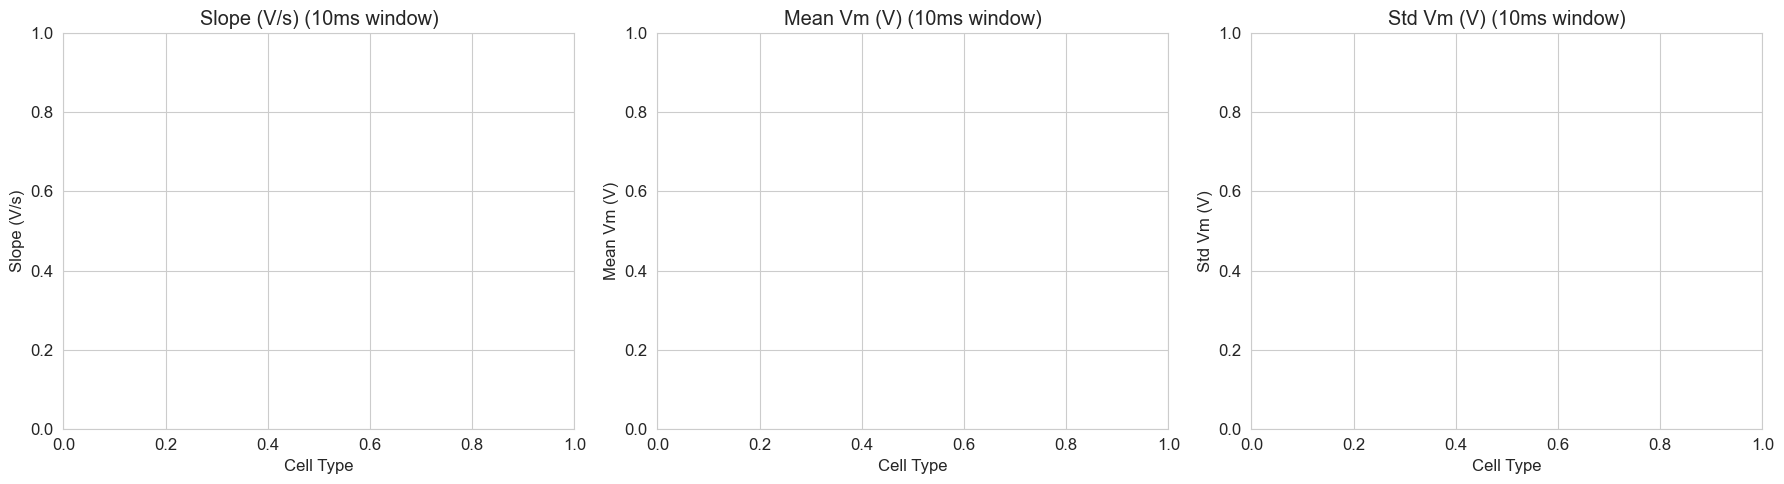

In [7]:
# =========================
# 2. VISUALIZATION: Pre-AP vs Baseline
# =========================

# Filter for a specific window size for the main plot (e.g., 10ms)
target_win = 10 
df_plot = df_part4[df_part4['win_ms'] == target_win]

# Define the features to plot
features = [
    ('slope_V_per_s', 'Slope (V/s)'), 
    ('mean_V', 'Mean Vm (V)'), 
    ('std_V', 'Std Vm (V)')
]

plt.figure(figsize=(18, 5))

for i, (col, ylabel) in enumerate(features):
    plt.subplot(1, 3, i+1)
    
    # Use a boxplot or violinplot to compare distributions
    sns.violinplot(
        data=df_plot, 
        x='cell_type', 
        y=col, 
        hue='condition', 
        split=True,       # Split the violin to see Pre-AP vs Baseline side-by-side
        inner='quart',
        palette='muted'
    )
    
    plt.title(f"{ylabel} ({target_win}ms window)")
    plt.ylabel(ylabel)
    plt.xlabel("Cell Type")
    
    if i > 0:
        plt.legend([],[], frameon=False) # Hide legend for subsequent plots

plt.tight_layout()
plt.show()

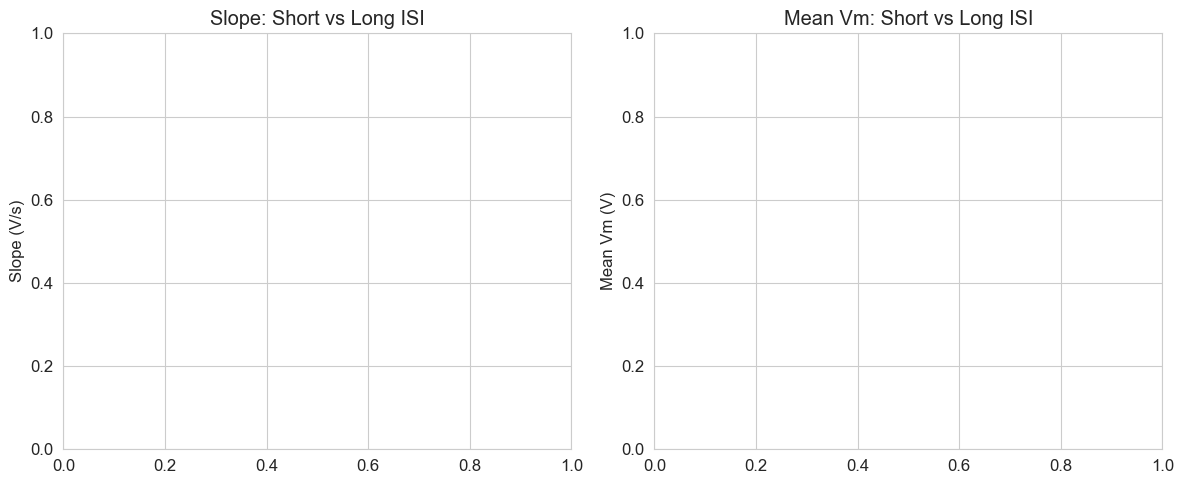

In [8]:
# =========================
# 3. VISUALIZATION: Impact of ISI (Pre-AP only)
# =========================

# We only look at "Pre-AP" condition to compare Short vs Long history
df_isi = df_part4[
    (df_part4['condition'] == 'Pre-AP') & 
    (df_part4['win_ms'] == 10) & 
    (df_part4['isi_cat'].isin(['Short', 'Long'])) # Compare extremes
]

plt.figure(figsize=(12, 5))

# Plot Slope vs Cell Type, split by ISI Category
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df_isi, 
    x='cell_type', 
    y='slope_V_per_s', 
    hue='isi_cat',
    palette='Set2'
)
plt.title("Slope: Short vs Long ISI")
plt.ylabel("Slope (V/s)")

# Plot Threshold (Anchor Vm) vs Cell Type, split by ISI
# Note: t_anchor_s is time, you might want the voltage at anchor
# But mean_V is a good proxy for the subthreshold level
plt.subplot(1, 2, 2)
sns.boxplot(
    data=df_isi, 
    x='cell_type', 
    y='mean_V', 
    hue='isi_cat',
    palette='Set2'
)
plt.title("Mean Vm: Short vs Long ISI")
plt.ylabel("Mean Vm (V)")

plt.tight_layout()
plt.show()

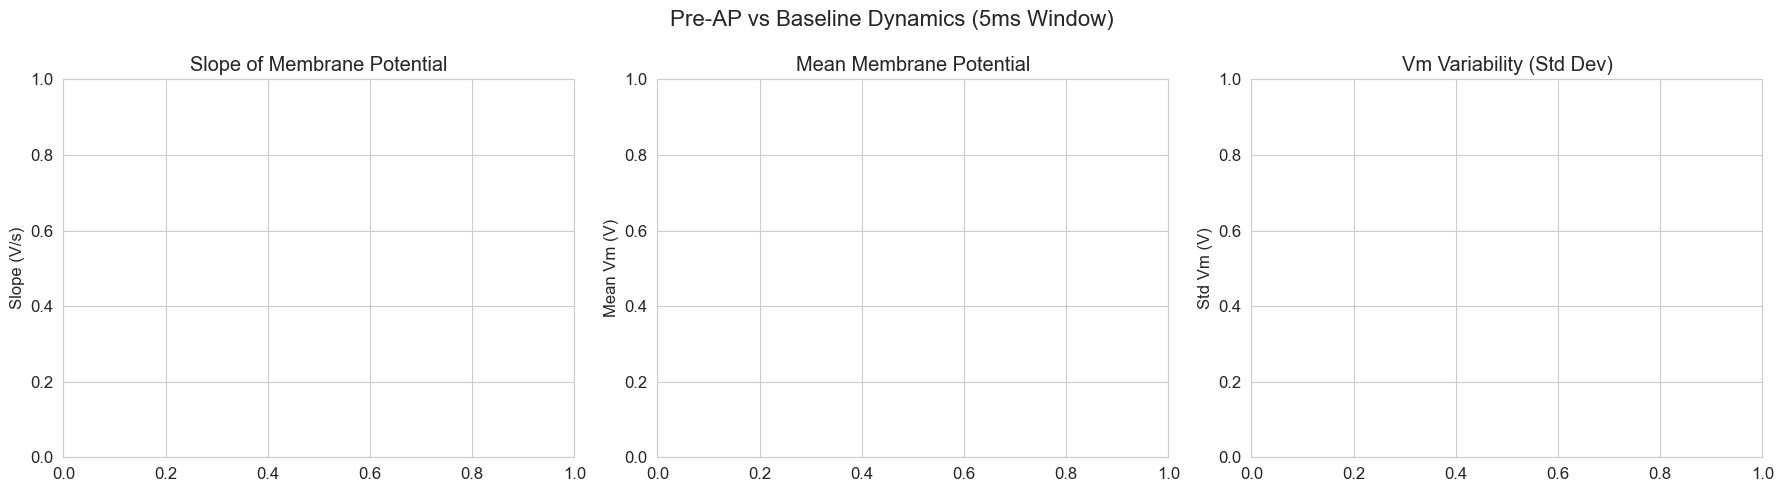

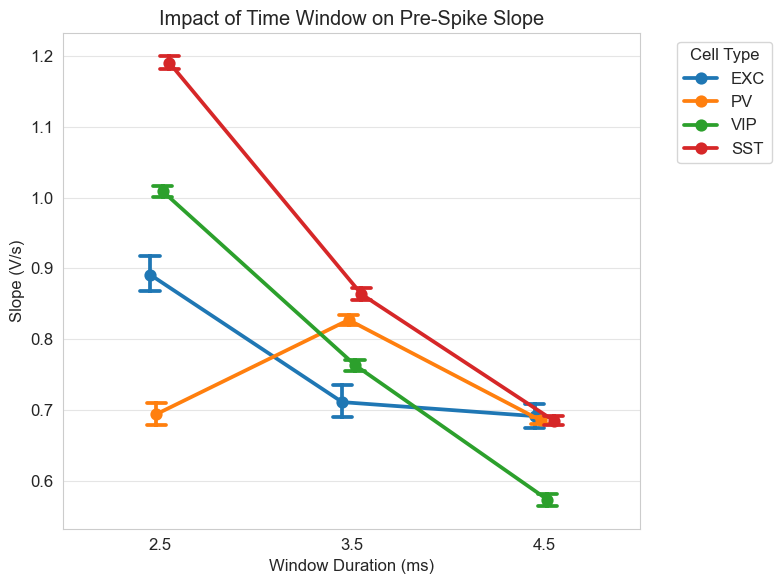

Not enough data in Short/Long ISI categories to plot Figure 3.


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# ==========================================================
# FIGURE 1: Pre-AP vs Baseline (Can we predict a spike?)
# ==========================================================
# We focus on the 5ms window for the main comparison as it captures
# the immediate pre-spike dynamics best.
win_to_plot = 5 
df_fig1 = df_part4[df_part4['win_ms'] == win_to_plot]

fig1, axes = plt.subplots(1, 3, figsize=(18, 5))
fig1.suptitle(f'Pre-AP vs Baseline Dynamics ({win_to_plot}ms Window)', fontsize=16)

# 1A. Slope
sns.boxplot(ax=axes[0], x='cell_type', y='slope_V_per_s', hue='condition', 
            data=df_fig1, palette={'Pre-AP': '#d62728', 'Baseline': '#aec7e8'}, 
            showfliers=False) # Hiding outliers makes the box comparison clearer
axes[0].set_title('Slope of Membrane Potential')
axes[0].set_ylabel('Slope (V/s)')

# 1B. Mean Vm
sns.boxplot(ax=axes[1], x='cell_type', y='mean_V', hue='condition', 
            data=df_fig1, palette={'Pre-AP': '#d62728', 'Baseline': '#aec7e8'}, 
            showfliers=False)
axes[1].set_title('Mean Membrane Potential')
axes[1].set_ylabel('Mean Vm (V)')

# 1C. Std Vm (Fluctuations)
sns.boxplot(ax=axes[2], x='cell_type', y='std_V', hue='condition', 
            data=df_fig1, palette={'Pre-AP': '#d62728', 'Baseline': '#aec7e8'}, 
            showfliers=False)
axes[2].set_title('Vm Variability (Std Dev)')
axes[2].set_ylabel('Std Vm (V)')

plt.tight_layout()
plt.show()


# ==========================================================
# FIGURE 2: Time Scales (Does window size matter?)
# ==========================================================
# We only look at Pre-AP windows to see how the "signal" changes over time.
df_fig2 = df_part4[df_part4['condition'] == 'Pre-AP']

plt.figure(figsize=(8, 6))
sns.pointplot(x='win_ms', y='slope_V_per_s', hue='cell_type', 
              data=df_fig2, dodge=True, markers='o', capsize=0.1)

plt.title('Impact of Time Window on Pre-Spike Slope')
plt.xlabel('Window Duration (ms)')
plt.ylabel('Slope (V/s)')
plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()


# ==========================================================
# FIGURE 3: History Dependence (Short vs Long ISI)
# ==========================================================
# Compare "Short" (bursts) vs "Long" (isolated) for Pre-AP windows.
# We use the 5ms window again as it's most sensitive to immediate dynamics.
df_fig3 = df_part4[
    (df_part4['condition'] == 'Pre-AP') & 
    (df_part4['win_ms'] == 5) &
    (df_part4['isi_cat'].isin(['Short', 'Long']))
]

if not df_fig3.empty:
    fig3, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig3.suptitle('Effect of Recent Spiking History (ISI) on Pre-Spike Dynamics', fontsize=16)

    # 3A. Slope
    sns.boxplot(ax=axes[0], x='cell_type', y='slope_V_per_s', hue='isi_cat', 
                data=df_fig3, palette='Set2', showfliers=False)
    axes[0].set_title('Slope: Short vs Long ISI')
    axes[0].set_ylabel('Slope (V/s)')

    # 3B. Mean Vm (Threshold approximation)
    sns.boxplot(ax=axes[1], x='cell_type', y='mean_V', hue='isi_cat', 
                data=df_fig3, palette='Set2', showfliers=False)
    axes[1].set_title('Mean Vm (Threshold): Short vs Long ISI')
    axes[1].set_ylabel('Mean Vm (V)')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough data in Short/Long ISI categories to plot Figure 3.")

In [ ]:
#VIP 

# =========================
# Parameters
# =====================
# Window durations to analyze (in ms)
WINDOWS_MS = [2.5, 3.5, 4.5]  
N_BASELINE_PER_SPIKE = 1


# Short: High freq bursts (10ms = 100Hz)
SHORT_ISI_MS = 3 

# Long: Rested state 
LONG_ISI_MS = 5  

# ======================================================
# 1. DEFINE THE DATA EXTRACTION HELPER FUNCTION
# ======================================================
def get_trace_from_row(row):
    """
    Extracts t, vm, and parameters from a single row of the DataFrame.
    """
    # Verify your column names here. 
    # Usually 'Sweep_MembranePotential' or 'vm_trace' depending on your cleaning step.
    vm = row['Sweep_MembranePotential'] 
    fs = row['Sweep_MembranePotential_SamplingRate']
    
    dt = 1.0 / fs
    t = np.arange(len(vm)) * dt
    
    cell_type = row['Cell_Type'] if 'Cell_Type' in row else 'Unknown'
    
    # Use provided threshold slope or default
    if 'Cell_APThreshold_Slope' in row:
        ap_slope_thr = row['Cell_APThreshold_Slope']
    else:
        ap_slope_thr = 20.0 
        
    return t, vm, fs, cell_type, ap_slope_thr

# ======================================================
# 2. MAIN ANALYSIS LOOP
# ======================================================
rows = []
print(f"Starting analysis on {len(data_df)} sweeps...")

for idx, row in data_df.iterrows():
    
    # --- A. Get Trace Data ---
    try:
        t, vm, fs, cell_type, ap_slope_thr = get_trace_from_row(row)
    except Exception as e:
        continue

    # --- B. Detect Spikes ---
    ap_out = Function_Detect_APs(vm, fs, ap_slope_thr)

    if ap_out is None or len(ap_out) == 0:
        continue
        
    # t_thr_list in seconds
    t_thr_list = ap_out[:, 0]
    t_thr_list = np.sort(t_thr_list)

    # --- C. Analyze Each Spike ---
    for k, t_thr in enumerate(t_thr_list):

        # 1. Calculate ISI (History)
        isi_ms = np.nan
        isi_cat = None
        
        # We can only calculate ISI if there is a previous spike (k > 0)
        if k > 0:
            isi_ms = (t_thr - t_thr_list[k - 1]) * 1000.0
            
            # Categorize based on your NEW physiological thresholds
            if isi_ms < SHORT_ISI_MS:
                isi_cat = "Short" # < 10ms
            elif isi_ms > LONG_ISI_MS:
                isi_cat = "Long"  # > 50ms
            else:
                isi_cat = "Mid"   # 10ms - 50ms

        # 2. Extract Pre-AP Windows
        for win_ms in WINDOWS_MS:
            vm_seg, t_seg = extract_pre_spike_window(vm, t, t_thr, win_ms, t_thr_list)
            
            if vm_seg is None:
                continue

            slope, mean_vm, std_vm = compute_features(vm_seg, t_seg)

            rows.append({
                "cell_id": row.name, 
                "cell_type": cell_type,
                "condition": "Pre-AP",
                "win_ms": win_ms,
                "slope_V_per_s": slope,
                "mean_V": mean_vm,
                "std_V": std_vm,
                "t_anchor_s": t_thr,
                "isi_ms": isi_ms,
                "isi_cat": isi_cat
            })

            # 3. Extract Baseline Windows
            # Only do this ONCE per spike (not for every window size) to save time,
            # or do it for every window size if you want matched controls.
            # Your current indentation does it for every window size, which is correct.
            for _ in range(N_BASELINE_PER_SPIKE):
                b_vm, b_t, t_rand = sample_baseline_window(
                    vm, t, t_thr_list, win_ms,
                    guard_pre_ms=20, guard_post_ms=10
                )
                if b_vm is None:
                    continue

                b_slope, b_mean, b_std = compute_features(b_vm, b_t)

                rows.append({
                    "cell_id": row.name,
                    "cell_type": cell_type,
                    "condition": "Baseline",
                    "win_ms": win_ms,
                    "slope_V_per_s": b_slope,
                    "mean_V": b_mean,
                    "std_V": b_std,
                    "t_anchor_s": t_rand,
                    "isi_ms": np.nan, # Baseline has no specific ISI
                    "isi_cat": None
                })

# Create final DataFrame
df_part4 = pd.DataFrame(rows)
print("Analysis Done.")
print(f"Result shape: {df_part4.shape}")

# Check how many you got in each category
print(df_part4[df_part4['condition']=='Pre-AP']['isi_cat'].value_counts())